# CS6140 Project - Detection Of Sarcasm In Text

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
import gensim.downloader as api
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
import math

In [2]:
#Run if running notebook with vectors locally for first time. Files added to gitignore
#glove = api.load('glove-wiki-gigaword-300')
#glove.save('glovevectors.bin')

In [3]:
glove = KeyedVectors.load('glovevectors.bin')

In [4]:
# Run these if not up to date
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
torch.cuda.is_available()

True

In [6]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [8]:
data = pd.read_csv("train-balanced-sarcasm.csv")

In [9]:
data = data[['label', 'comment', 'subreddit', 'score', 'parent_comment']]

In [10]:
data.head(10)

,label,comment,subreddit,score,parent_comment
0,0,NC and NH.,politics,2,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,-4,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,3,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",AskReddit,0,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,AskReddit,1,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,FFBraveExvius,2,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",pcmasterrace,1,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,Lollapalooza,2,Probably count Kanye out Since the rest of his...


In [11]:
data.isna().sum()

label              0
comment           53
subreddit          0
score              0
parent_comment     0
dtype: int64

In [12]:
data = data.dropna(axis=0)

In [13]:
data.isna().sum()

label             0
comment           0
subreddit         0
score             0
parent_comment    0
dtype: int64

In [14]:
data['comment_tokens'] = data['comment']
data['comment_tokens'] = data['comment_tokens'].str.lower()
data['comment_tokens'] = data['comment_tokens'].str.replace('can\'t','can not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('\'d',' would',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [15]:
data['parent_comment_tokens'] = data['parent_comment']
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.lower()
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('can\'t','can not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('\'d',' would',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [16]:
lemma = WordNetLemmatizer()
def apply_lemmatizer(sentence):
    return [lemma.lemmatize(token) for token in wordpunct_tokenize(sentence)]

In [17]:
data["comment_tokens"] = data.comment_tokens.apply(apply_lemmatizer)
data["parent_comment_tokens"] = data.parent_comment_tokens.apply(apply_lemmatizer)

In [18]:
data[["comment", "comment_tokens"]].head(10)

,comment,comment_tokens
0,NC and NH.,"[nc, and, nh]"
1,You do know west teams play against west teams...,"[you, do, know, west, team, play, against, wes..."
2,"They were underdogs earlier today, but since G...","[they, were, underdog, earlier, today, but, si..."
3,"This meme isn't funny none of the ""new york ni...","[this, meme, isnt, funny, none, of, the, new, ..."
4,I could use one of those tools.,"[i, could, use, one, of, those, tool]"
5,"I don't pay attention to her, but as long as s...","[i, dont, pay, attention, to, her, but, a, lon..."
6,Trick or treating in general is just weird...,"[trick, or, treating, in, general, is, just, w..."
7,Blade Mastery+Masamune or GTFO!,"[blade, masterymasamune, or, gtfo]"
8,"You don't have to, you have a good build, buy ...","[you, dont, have, to, you, have, a, good, buil..."
9,I would love to see him at lolla.,"[i, would, love, to, see, him, at, lolla]"


In [19]:
data['comment_tokens'].shape

(1010773,)

In [20]:
data[["parent_comment", "parent_comment_tokens"]].head(10)

,parent_comment,parent_comment_tokens
0,"Yeah, I get that argument. At this point, I'd ...","[yeah, i, get, that, argument, at, this, point..."
1,The blazers and Mavericks (The wests 5 and 6 s...,"[the, blazer, and, maverick, the, west, 5, and..."
2,They're favored to win.,"[theyre, favored, to, win]"
3,deadass don't kill my buzz,"[deadass, dont, kill, my, buzz]"
4,Yep can confirm I saw the tool they use for th...,"[yep, can, confirm, i, saw, the, tool, they, u..."
5,do you find ariana grande sexy ?,"[do, you, find, ariana, grande, sexy]"
6,What's your weird or unsettling Trick or Treat...,"[whats, your, weird, or, unsettling, trick, or..."
7,Probably Sephiroth. I refuse to taint his grea...,"[probably, sephiroth, i, refuse, to, taint, hi..."
8,What to upgrade? I have $500 to spend (mainly ...,"[what, to, upgrade, i, have, 500, to, spend, m..."
9,Probably count Kanye out Since the rest of his...,"[probably, count, kanye, out, since, the, rest..."


In [21]:
data['parent_comment_tokens'].shape

(1010773,)

In [22]:
X = data[['comment_tokens', 'parent_comment_tokens']]

In [23]:
X.head(10)

,comment_tokens,parent_comment_tokens
0,"[nc, and, nh]","[yeah, i, get, that, argument, at, this, point..."
1,"[you, do, know, west, team, play, against, wes...","[the, blazer, and, maverick, the, west, 5, and..."
2,"[they, were, underdog, earlier, today, but, si...","[theyre, favored, to, win]"
3,"[this, meme, isnt, funny, none, of, the, new, ...","[deadass, dont, kill, my, buzz]"
4,"[i, could, use, one, of, those, tool]","[yep, can, confirm, i, saw, the, tool, they, u..."
5,"[i, dont, pay, attention, to, her, but, a, lon...","[do, you, find, ariana, grande, sexy]"
6,"[trick, or, treating, in, general, is, just, w...","[whats, your, weird, or, unsettling, trick, or..."
7,"[blade, masterymasamune, or, gtfo]","[probably, sephiroth, i, refuse, to, taint, hi..."
8,"[you, dont, have, to, you, have, a, good, buil...","[what, to, upgrade, i, have, 500, to, spend, m..."
9,"[i, would, love, to, see, him, at, lolla]","[probably, count, kanye, out, since, the, rest..."


In [24]:
Y = data[['label']]

In [25]:
Y.tail(10)

,label
1010816,1
1010817,1
1010818,1
1010819,1
1010820,1
1010821,1
1010822,1
1010823,1
1010824,1
1010825,1


In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size= 0.6)

In [27]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size = 0.5) 

In [28]:
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [29]:
y_train = y_train.reset_index(drop = True)
y_valid = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [30]:
X_train.head(10)

,comment_tokens,parent_comment_tokens
0,"[a, someone, working, my, way, into, 512, gym,...","[my, so, call, it, the, universal, climber, st..."
1,"[yeh, be, yourself, your, uncool, white, self]","[the, man, saying, dont, try, to, be, someone,..."
2,"[yes, for, the, first, two, i, see, that, it, ...","[is, that, what, cause, the, crash, are, these..."
3,"[thats, what, the, hawk, get, for, wearing, th...","[vucevic, hit, the, game, winner]"
4,"[my, condolence, on, the, loss, of, your, brot...","[lent, my, brotherinlaw, my, ps2, this, is, ho..."
5,"[do, you, think, we, should, bring, back, la, ...","[awesome, im, fairly, familiar, with, 100, luc..."
6,"[password, recovery, isnt, implemented, yet]","[how, do, i, reset, the, password, i, can, not..."
7,"[strange, i, thought, everybody, replied, to, ...",[negative]
8,"[im, inclined, to, think, it, wa, meant, a, a,...","[what, the, hell, crawled, up, your, as, go, p..."
9,"[assad, had, to, destroy, the, town, in, order...","[largely, because, theyve, got, sane, rule, of..."


In [31]:
len(X_train)

606463

In [32]:
data.shape

(1010773, 7)

In [33]:
# Since comments are already preprocessed and tokenized,
# the vectorizer only needs to take tokens as they are.
tfidfVectorizer = TfidfVectorizer(analyzer=lambda tokens: tokens)
corpus = pd.concat([X_train['comment_tokens'], X_train['parent_comment_tokens']])
tfidfMatrix = tfidfVectorizer.fit_transform(corpus)
vocabulary = tfidfVectorizer.vocabulary_

In [34]:
tfidfMatrix.shape

(1212926, 284048)

In [35]:
# the tfidf matrix has 2021546 rows,
# where the 0 ~ 606462 rows represent original comments in the same order as those in dataset,
# and the 606463 ~ 1212926 rows represent parent comments in the same order as those in dataset;
# and the tfidf matrix has 395961 columns, each represents a word in the vocabulary.
tfidfMatrix

<1212926x284048 sparse matrix of type '<class 'numpy.float64'>'
	with 17840926 stored elements in Compressed Sparse Row format>

In [36]:
# By using the following dict, we can obtain the index of a given word for querying tfidf matrix.
vocabulary

{'a': 18913,
 'someone': 234219,
 'working': 277116,
 'my': 169741,
 'way': 271843,
 'into': 131278,
 '512': 13417,
 'gym': 114750,
 'route': 216518,
 'that': 249553,
 'shirt': 227366,
 'is': 132332,
 'dope': 81010,
 'yeh': 280863,
 'be': 38897,
 'yourself': 281819,
 'your': 281783,
 'uncool': 261395,
 'white': 274175,
 'self': 223838,
 'yes': 281015,
 'for': 100484,
 'the': 249786,
 'first': 98223,
 'two': 259067,
 'i': 125643,
 'see': 223420,
 'it': 132933,
 'usually': 265051,
 'this': 250971,
 'attack': 33201,
 'though': 251278,
 'thats': 249653,
 'what': 273688,
 'hawk': 117854,
 'get': 107873,
 'wearing': 272208,
 'those': 251252,
 'short': 228067,
 'with': 275981,
 'jersey': 135189,
 'condolence': 63552,
 'on': 181811,
 'loss': 151242,
 'of': 180314,
 'brotherinlaw': 48482,
 'do': 79832,
 'you': 281595,
 'think': 250804,
 'we': 272054,
 'should': 228264,
 'bring': 47907,
 'back': 35670,
 'la': 143918,
 'momia': 165670,
 'password': 188354,
 'recovery': 208506,
 'isnt': 132685,
 '

Once we have learned word vectors, to compute the sentence vector of a comment,
first fetch the corresponding row from the tfidf matrix (if it is the i-th original comment, then
it is the i-th row; if it is the i-th parent comment, then it is the (1010773 + i)-th row),
second for each word in the comment find its corresponding tfidf value from the row,
third compute the average of the word vectors weighted by corresponding tfidf values.

In [37]:
tfidfMatrix.shape

(1212926, 284048)

In [38]:
tfidfMatrix[0,249920]

0.0

In [39]:
vocabulary['thats']

249653

In [40]:
tfidfMatrixtest = tfidfVectorizer.transform(pd.concat([X_test['comment_tokens'], X_test['parent_comment_tokens']]))
tfidfMatrixvalid = tfidfVectorizer.transform(pd.concat([X_val['comment_tokens'], X_val['parent_comment_tokens']]))

In [41]:
tfidfMatrixtest.shape

(404310, 284048)

In [42]:
X_test.head(10)

,comment_tokens,parent_comment_tokens
0,"[yeah, it, ended, up, being, just, indigestion]","[wa, the, old, woman, okay]"
1,"[i, feel, like, some, of, my, headshot, even, ...","[providing, you, can, track, people, very, wel..."
2,[bitpay],"[i, want, to, take, bitcoin, for, my, business..."
3,"[are, they, actually, any, different, then, re...","[get, supreme, one, pleb]"
4,"[why, would, she, imitate, rather, than, do, h...","[im, really, impressed, with, how, well, she, ..."
5,"[thr, final, mash, episode, back, in, the, ear...","[what, wa, the, last, filmtv, series, you, cri..."
6,"[sound, like, local, government, either, have,...","[what, can, i, do, about, this]"
7,"[way, to, over, react]","[let, actually, not, because, mass, shooting, ..."
8,"[well, i, retract, my, statement, about, the, ...","[yes, the, galaxy, s7, is, well, known, for, n..."
9,[oeuf],"[yeacould, be, could, have, been, melon, melon..."


In [43]:
vocabulary['for']

100484

In [44]:
tfidfMatrixtest[0, 100573]

0.0

In [45]:
def generate_dataset(X, tfidfmat):
    comment_featurevec = []
    parent_featurevec = []
    
    for index, sample in X.iterrows():
        
        comment_vec = np.zeros(300)
        parent_comment_vec = np.zeros(300)
        comment_tokens = sample['comment_tokens']
        parent_comment_tokens = sample['parent_comment_tokens']
        counter1 = 0
        
        for token in comment_tokens:
            
            if token in glove and token in vocabulary:
                counter1 += 1
                comment_vec += tfidfmat[index, vocabulary[token]] * glove[token]
        
        counter2 = 0
        for token in parent_comment_tokens:
            
            if token in glove and token in vocabulary:
                counter2 += 1 
                parent_comment_vec += tfidfmat[index+len(X), vocabulary[token]] * glove[token]
        
        if counter1 != 0:
            comment_featurevec.append(comment_vec/counter1)
        else:
            comment_featurevec.append(comment_vec)
        
        if counter2 != 0:
            parent_featurevec.append(parent_comment_vec/counter2)
        else:
            parent_featurevec.append(parent_comment_vec)
            
        
    #print(len(comment_featurevec))
    X['comment_weighted_vec'] = comment_featurevec
    X['parent_weighted_vec'] = parent_featurevec
    new_df = pd.DataFrame()
        
    return X
    
    
    

In [46]:
X_train = generate_dataset(X_train, tfidfMatrix)

In [47]:
X_val = generate_dataset(X_val, tfidfMatrixvalid)

In [48]:
X_test = generate_dataset(X_test, tfidfMatrixtest)

In [49]:
X_train = X_train[['comment_weighted_vec', 'parent_weighted_vec']]
X_val = X_val[['comment_weighted_vec', 'parent_weighted_vec']]
X_test = X_test[['comment_weighted_vec', 'parent_weighted_vec']]

In [50]:
def featurize(dataset):
    x = pd.DataFrame(dataset['parent_weighted_vec'].tolist(), columns = [i for i in range(300)])
    y = pd.DataFrame(dataset['comment_weighted_vec'].tolist(), columns = [i for i in range(300, 600)])
    return pd.concat([x, y], axis = 1)

In [51]:
X_train = featurize(X_train)
X_val = featurize(X_val)
X_test = featurize(X_test)

In [52]:
clf = LogisticRegression(max_iter = 500).fit(X_train, y_train.values.ravel())

In [53]:
clf.score(X_test, y_test)

0.5964977368850635

In [54]:
clf.score(X_val, y_val)

0.5935643441913383

In [55]:
clf.predict(X_test.iloc[2].values.reshape(1,-1))

array([1])

Feed Forward Neural Net Begin....

In [70]:
x_tr = torch.tensor(X_train.iloc[:,0:600].values, dtype= torch.float32)
x_val = torch.tensor(X_val.iloc[:,0:600].values, dtype= torch.float32)
x_test = torch.tensor(X_test.iloc[:,0:600].values,dtype= torch.float32)
y_tr = torch.tensor(list(y_train['label']), dtype= torch.long)
y_vali = torch.tensor(list(y_val['label']), dtype= torch.long)
y_tst = torch.tensor(list(y_test['label']), dtype= torch.long)

In [71]:
x_tr.to(device)

tensor([[-0.0248,  0.0141, -0.0494,  ..., -0.0317,  0.0076,  0.0226],
        [-0.0096, -0.0013, -0.0602,  ..., -0.0546, -0.0038,  0.0154],
        [-0.0444,  0.0113, -0.0118,  ..., -0.0727, -0.0282,  0.0099],
        ...,
        [-0.0440,  0.0138, -0.0153,  ...,  0.0837, -0.0454, -0.0131],
        [ 0.0214,  0.0437,  0.0123,  ..., -0.0339, -0.0062, -0.0168],
        [-0.0095,  0.0027, -0.0059,  ..., -0.0492,  0.0064, -0.0106]],
       device='cuda:0')

In [72]:
x_val.to(device)
x_test.to(device)
y_tr.to(device)
y_vali.to(device)
y_tst.to(device)

tensor([1, 0, 0,  ..., 0, 0, 1], device='cuda:0')

In [73]:
class XY(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [74]:
trainset = XY(x_tr, y_tr)
valset = XY(x_val, y_vali)
testset = XY(x_test, y_tst)

In [127]:
input_dim = 600
hidden_dim = 256
output_dim = 3
num_epochs = 100
batch_size = 128

In [128]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)

## 2. Models

In [129]:
class FFNN(nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim):
      super(FFNN, self).__init__()
      self.layers = [nn.Linear(input_dim, hidden_dim)]
      for i in range(1, layer_num):
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(hidden_dim, output_dim))

      self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        return x

In [130]:
model = FFNN(2, input_dim, hidden_dim, output_dim).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [131]:
train_losses = []
val_losses = []
val_loss_min = math.inf
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    
    model.train()
    for data, target in trainloader:
      optimizer.zero_grad()
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      optimizer.zero_grad() 
      loss = loss_fn(output, target)  
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
      inpt = []
    
    model.eval()
    for data, target in valloader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      val_loss += loss.item()
    
    train_losses.append(train_loss/len(trainloader))
    val_losses.append(val_loss/len(valloader))

    if val_loss <= val_loss_min:
      torch.save(model.state_dict(), 'model.pt')
      val_loss_min = val_loss 
    if (epoch + 1) % 20 == 0:
      print("Epoch completed: " + str(epoch+1) +
            f"\n\tTraining Loss: {train_losses[epoch]:.3f}" + 
            f"\n\tValidation Loss: {val_losses[epoch]:.3f}\n")

Epoch completed: 20
	Training Loss: 0.589
	Validation Loss: 0.571

Epoch completed: 40
	Training Loss: 0.572
	Validation Loss: 0.548

Epoch completed: 60
	Training Loss: 0.562
	Validation Loss: 0.537

Epoch completed: 80
	Training Loss: 0.556
	Validation Loss: 0.585

Epoch completed: 100
	Training Loss: 0.551
	Validation Loss: 0.589



In [132]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_val['label'].values))
model = FFNN(2, input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model.pt'))
with torch.no_grad():
    for index, row in X_val.iterrows():
        output = model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))
        
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65    100991
           1       0.65      0.64      0.64    101164

    accuracy                           0.65    202155
   macro avg       0.65      0.65      0.65    202155
weighted avg       0.65      0.65      0.65    202155



In [134]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_test['label'].values))
model = FFNN(2, input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('model.pt'))
with torch.no_grad():
    for index, row in X_test.iterrows():
        output = model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))
        
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65    101295
           1       0.65      0.64      0.65    100860

    accuracy                           0.65    202155
   macro avg       0.65      0.65      0.65    202155
weighted avg       0.65      0.65      0.65    202155



## 3. Evaluation

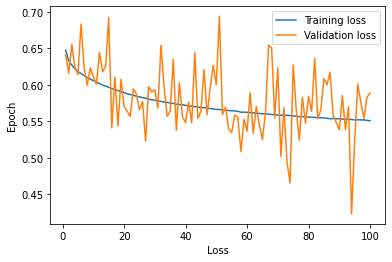

In [135]:
plt.plot(list(range(1,len(train_losses) + 1)), train_losses, label = "Training loss")
plt.plot(list(range(1,len(val_losses) +1)), val_losses, label = "Validation loss")
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.show()